## Processing Ocean Color Imagery

Basic goal of this notebook is to test out the full workflow and find the ideal viewing geometry

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd


import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

from utils import *

In [4]:
! ls data/20210407_duml_full_workflow_test/

all_imgs  panel_rededge  sea_rededge  sky_rededge
panel	  sea		 sky	      sunblocked_rededge


In [5]:
sky_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sky', 'stacks')
surface_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sea', 'stacks')

In [6]:
sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=70, start=30, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (70, 6, 1470, 2014)


In [7]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_dir, count=56, start=24, altitude_cutoff=0)

Output shape is:  (56, 6, 1470, 2014)


In [8]:
blocked_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sunblocked_rededge', 'stacks')

In [9]:
blocked_imgs, blocked_img_metadata = retrieve_imgs_and_metadata(blocked_dir, count=100, start=0, altitude_cutoff=0)

Output shape is:  (7, 5, 946, 1267)


In [10]:
sky_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sky_rededge', 'stacks')
surface_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sea_rededge', 'stacks')

In [11]:
sky_re_imgs, sky_re_img_metadata = retrieve_imgs_and_metadata(sky_dir_re, count=100, start=0, altitude_cutoff=0)
sea_re_imgs, sea_re_img_metadata = retrieve_imgs_and_metadata(surface_dir_re, count=100, start=0, altitude_cutoff=0)

Output shape is:  (4, 5, 946, 1267)
Output shape is:  (9, 5, 946, 1267)


only grab metadata

Open the md of each image and then sort by time and then I know the order of pitch

then I can sort by pitch and yaw

In [12]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

In [29]:
mds = load_img_fn_and_meta(sky_dir, count=None, start=0)
len(mds)

144

In [ ]:
mds

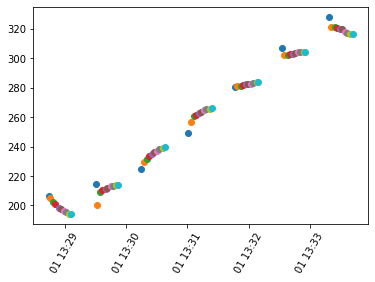

In [12]:
import datetime

for md in sea_img_metadata[:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

In [13]:
import datetime

for md in mds[24:136]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

NameError: name 'mds' is not defined

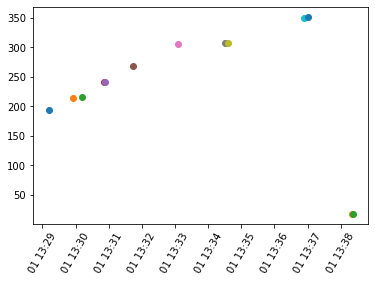

In [49]:
import datetime

for md in sky_img_metadata[2:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

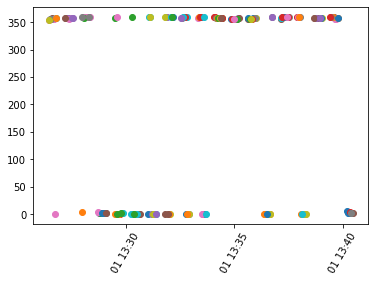

In [19]:
for md in mds:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['pitch'])
    plt.xticks(rotation=60)

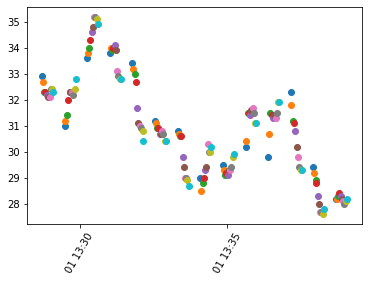

In [39]:
for md in mds[30:170]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['Altitude'])
    plt.xticks(rotation=60)

In [39]:
sea_imgs.nbytes / 1e9

9.9475488

In [40]:
sky_imgs.nbytes / 1e9

7.95803904

In [42]:
sea_img_metadata

[{'Latitude': 34.71521388888889,
  'Longitude': -76.67316666666667,
  'Altitude': 19.2,
  'UTC-Time': '13:26:26',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/21JUiicmpKbtesGKh4IH.tif',
  'filename': '21JUiicmpKbtesGKh4IH.tif',
  'yaw': 262.642578156496,
  'pitch': 353.93212970596005,
  'roll': 7.002910573085387,
  'id': 0},
 {'Latitude': 34.715205555555556,
  'Longitude': -76.67331111111112,
  'Altitude': 22.4,
  'UTC-Time': '13:26:31',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/RQhE0pS5CCMeizJqusiy.tif',
  'filename': 'RQhE0pS5CCMeizJqusiy.tif',
  'yaw': 264.38787546246033,
  'pitch': 355.1901069684007,
  'roll': 4.833103411427999,
  'id': 1},
 {'Latitude': 34.71520277777778,
  'Longitude': -76.67335555555556,
  'Altitude': 23.3,
  'UTC-Time': '13:26:33',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/5ijPfM21i1ddYpOwle8M.tif',
  'filename': 

Inspect the bands either through time or sorted by pitch/yaw/lat/ etc

In [14]:
sea_img_md_pitch_sort = sorted(sea_img_metadata[1:], key=lambda k: k['pitch'])

sky_img_md_pitch_sort = sorted(sky_img_metadata[2:], key=lambda k: k['pitch'])

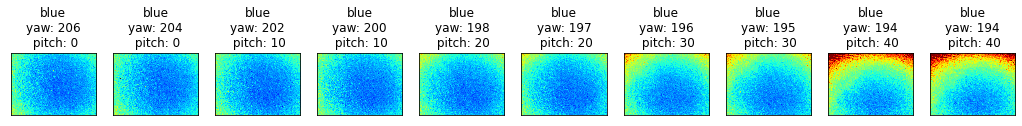

In [7]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


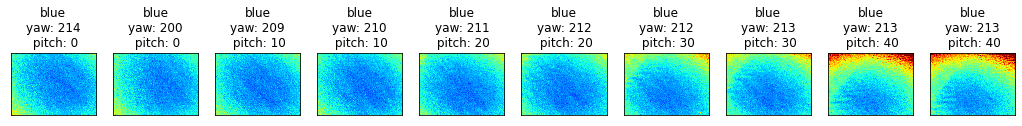

In [8]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+10]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+10][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


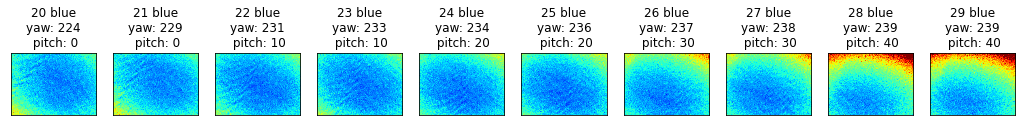

In [38]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title(str(i+20) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+20]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+20][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

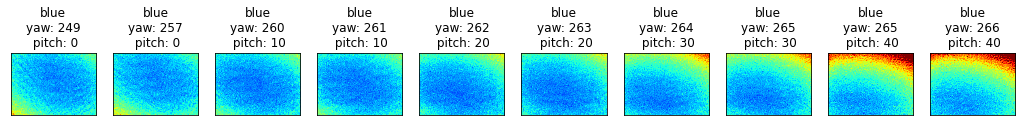

In [9]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+30]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+30][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

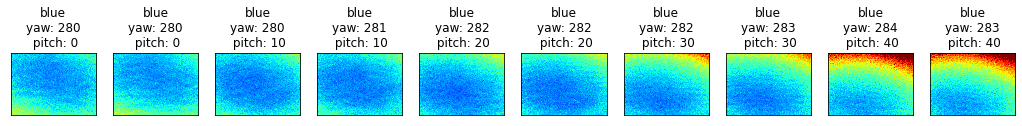

In [10]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+40]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+40][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

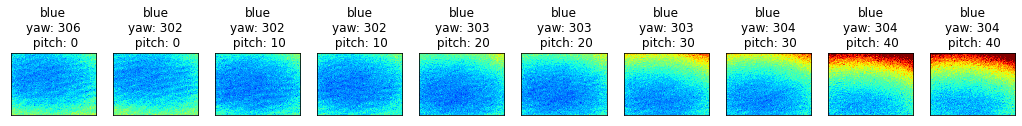

In [12]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+50]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+50][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

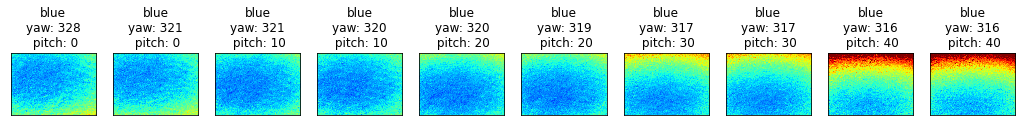

In [13]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+60]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+60][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

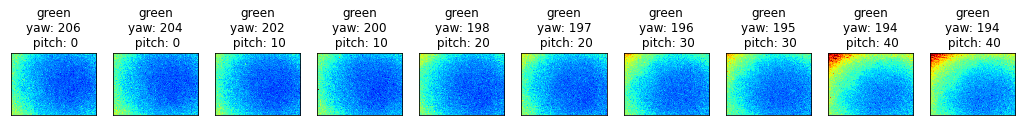

In [14]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+0]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+0][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

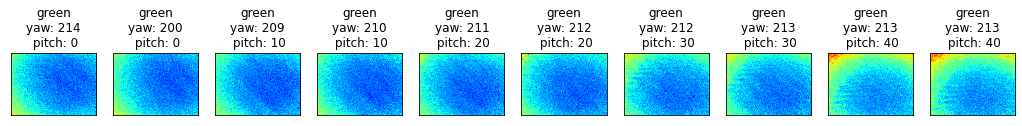

In [15]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+10]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+10][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

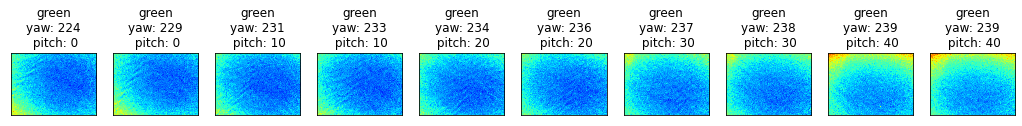

In [16]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+20]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+20][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

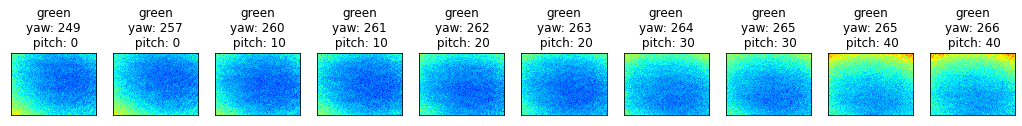

In [17]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+30]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+30][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

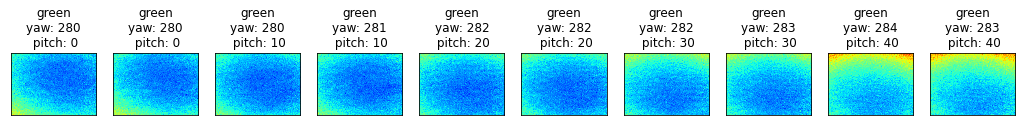

In [18]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+40]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+40][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

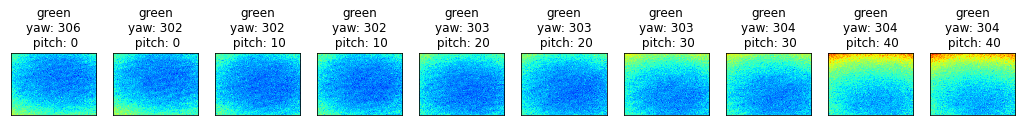

In [19]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+50]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+50][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

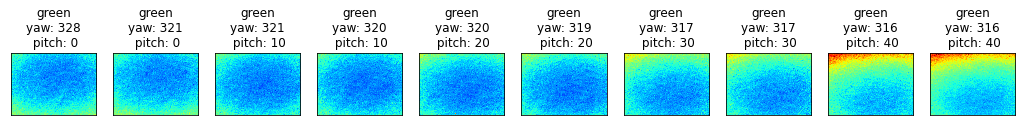

In [20]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+60]['yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+60][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [13]:
sky_img_md_pitch_sort= sorted(sky_img_metadata[:], key=lambda k: k['pitch']) 
len(sky_img_md_pitch_sort)

56

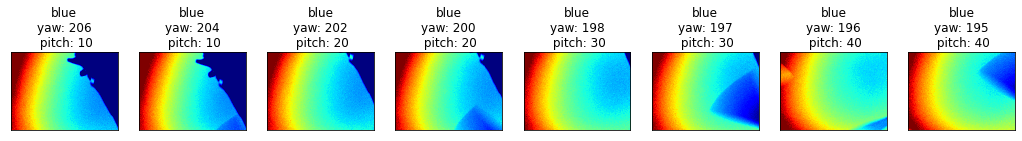

In [17]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*0]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

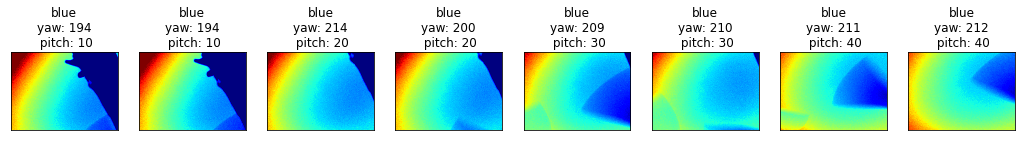

In [18]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*1]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

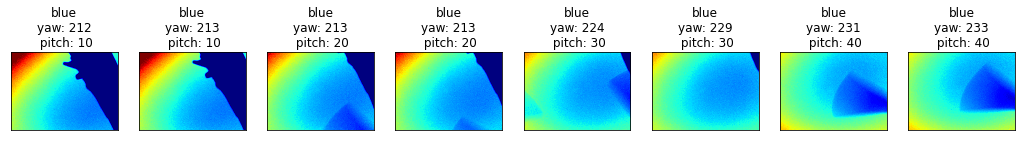

In [188]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    #ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*2]['yaw'])))
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*2]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*2][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

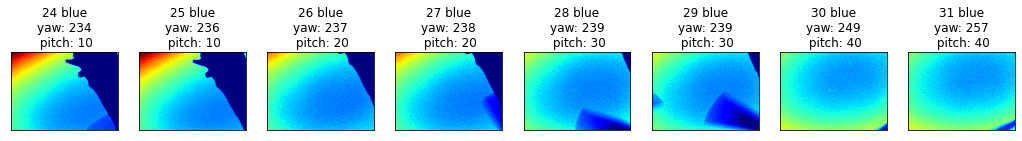

In [40]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title(str(i+8*3) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*3]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*3][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

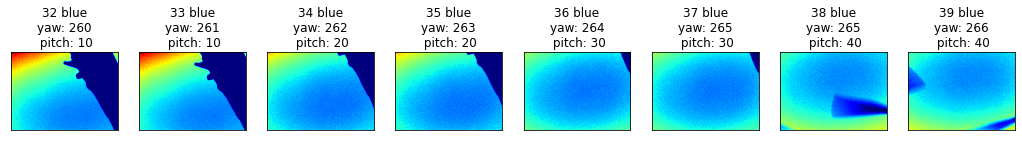

In [19]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title(str(i+8*4) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*4]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*4][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

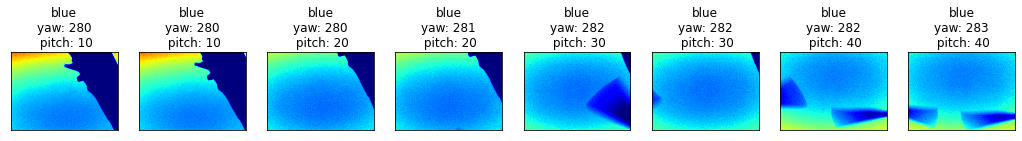

In [21]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*5]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*5][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

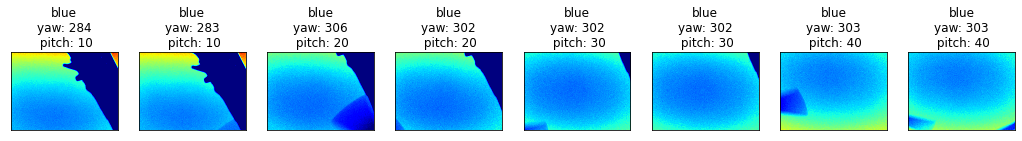

In [22]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*6]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*6][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

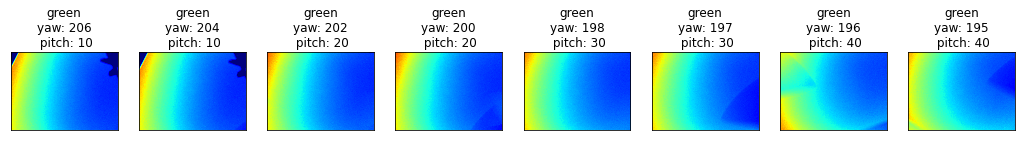

In [23]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+8*0]['yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i][1], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### inspect the sun blocked spectra based on the brightest pics there

In [94]:
blocked_imgs.shape

(7, 5, 945, 1268)

brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599


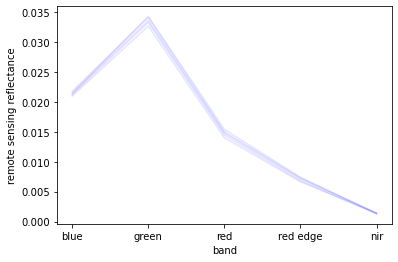

In [15]:
blocked_spectra = []
for i in range(0,5):
    spec = brightest_tube_pix(blocked_imgs[i], percent=0.0005)
    plt.plot(band_names, spec, color='blue', alpha=0.1)
    plt.ylabel('remote sensing reflectance')
    plt.xlabel('band')
    blocked_spectra.append(spec)
blocked_spectra = np.array(blocked_spectra)

### Visualize some of the rededge data for the correction

In [138]:
sky_re_imgs.shape, sea_re_imgs.shape

((4, 5, 946, 1267), (9, 5, 946, 1267))

pitch 55.22378489978678
231.59169870567823
pitch 59.981352264989084
249.39674060544104


/home/clifgray/Code/ocean_color/utils.py:434: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


pitch 59.28543112523056
248.81318506371252
pitch 59.609122592910694
248.2294867305343
pitch 59.68638973056699
246.60952223247872
pitch 61.014638603875596
242.58189136495963
pitch 55.40071388953356
240.43571902219384
pitch 55.12979555593489
239.19015596776558


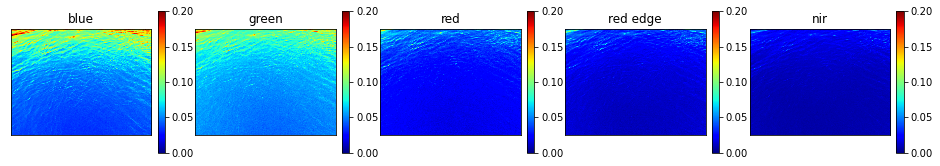

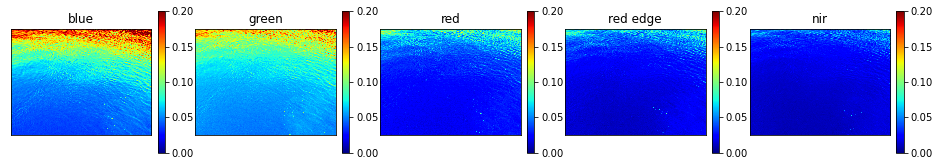

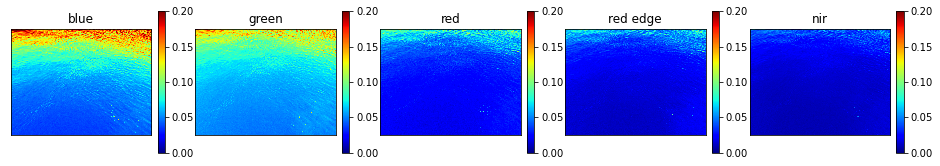

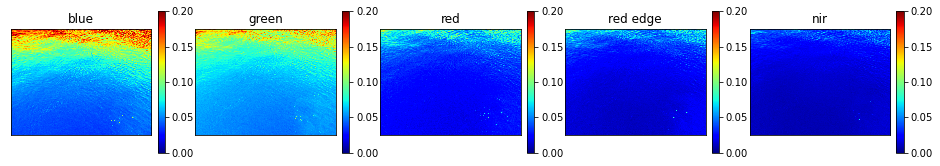

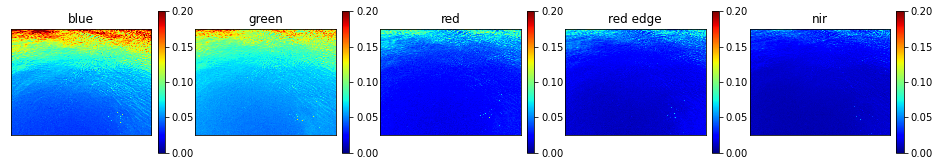

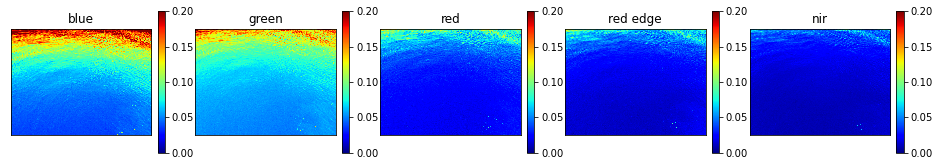

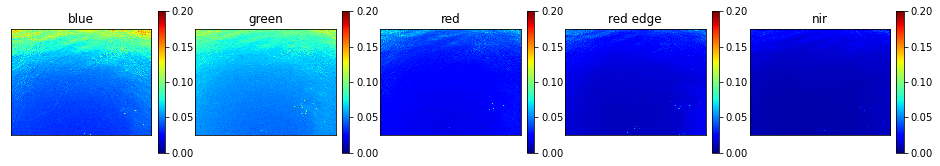

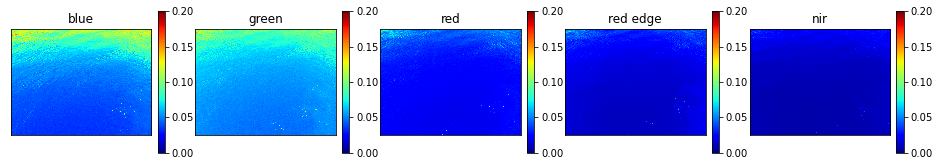

In [26]:
for i in range(0,8):
    print('pitch', sea_re_img_metadata[i]['pitch'])
    print(sea_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sea_re_imgs[i], lowest_percent=1, max_clim=0.2, only_img=True)

pitch 37.24920074044252
57.145434939278175
pitch 39.40261551786597
54.71224316974633
pitch 45.63918681770838
53.38104661148208
pitch 42.59217228666313
56.883200578649564


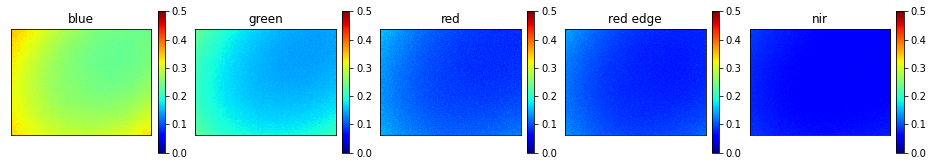

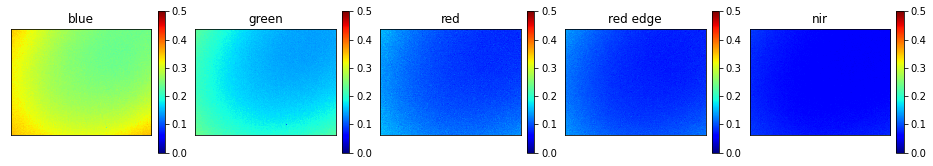

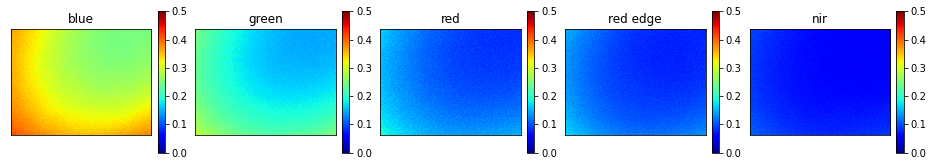

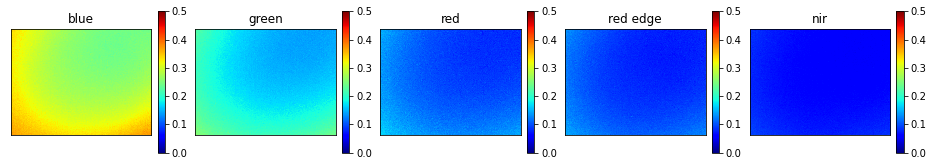

In [27]:
for i in range(0,4):
    print('pitch', sky_re_img_metadata[i]['pitch'])
    print(sky_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sky_re_imgs[i], lowest_percent=1, max_clim=0.5, only_img=True)

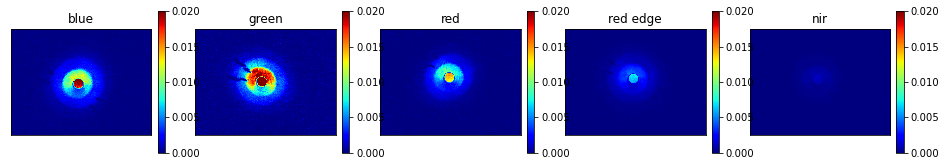

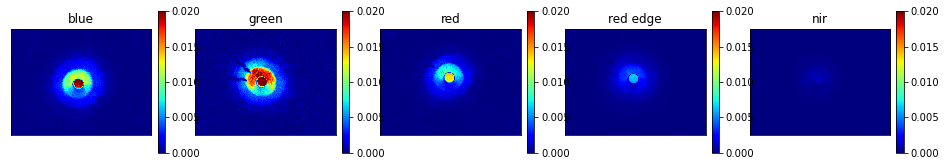

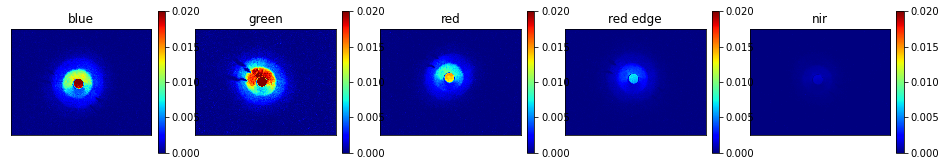

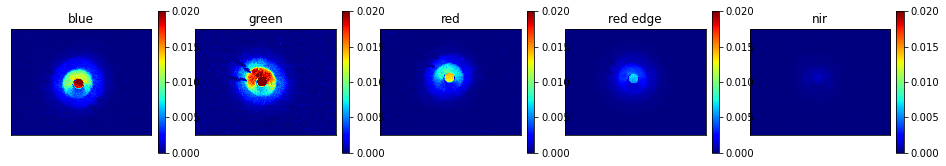

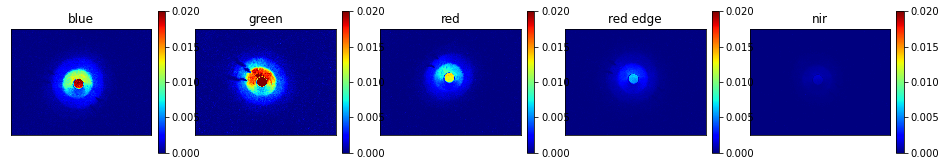

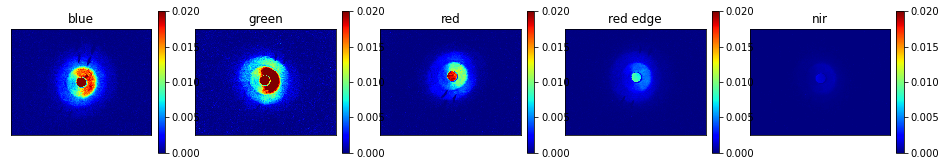

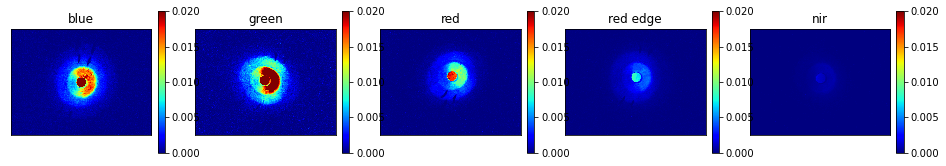

In [28]:
for i in range(0,7):
    visualize_darkest_pixels(blocked_imgs[i], lowest_percent=1, max_clim=0.02, only_img=True)

### Apply the sunblocked based approach

In [29]:
np.median(blocked_spectra,axis=0)

array([0.02212037, 0.03488749, 0.01545856, 0.00754759, 0.00149023])

#### Calculate rho by lt - lw / lsky

This is using the rededge images which seem to have some value mismatch and thus are off

(9, 5, 946, 1267)


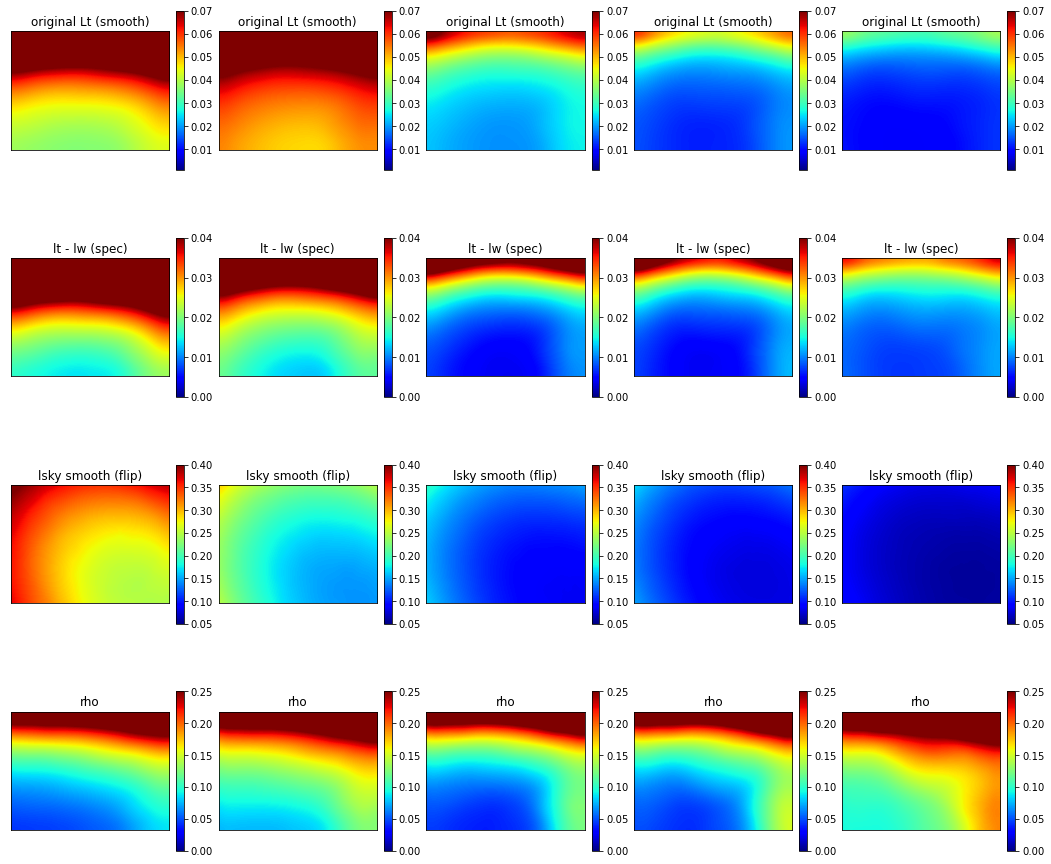

In [31]:
rho = calculate_rho(sea_re_imgs, 
              sky_re_imgs[2][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

Now using the images from the drone only

(1, 5, 1470, 2014)


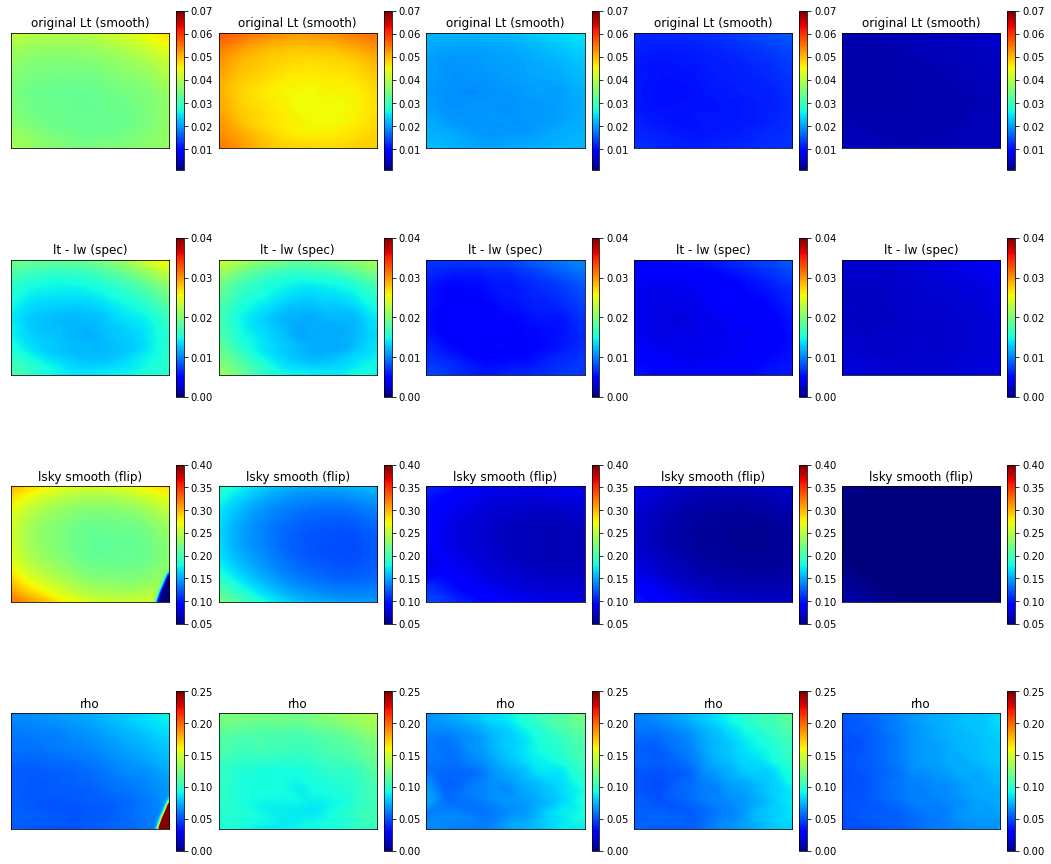

In [20]:
# trying it at the 20 degree off nadir image
rho = calculate_rho(sea_imgs[35,:5][np.newaxis,...], 
              sky_imgs[37,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(1, 5, 1470, 2014)


/home/clifgray/Code/ocean_color/utils.py:653: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


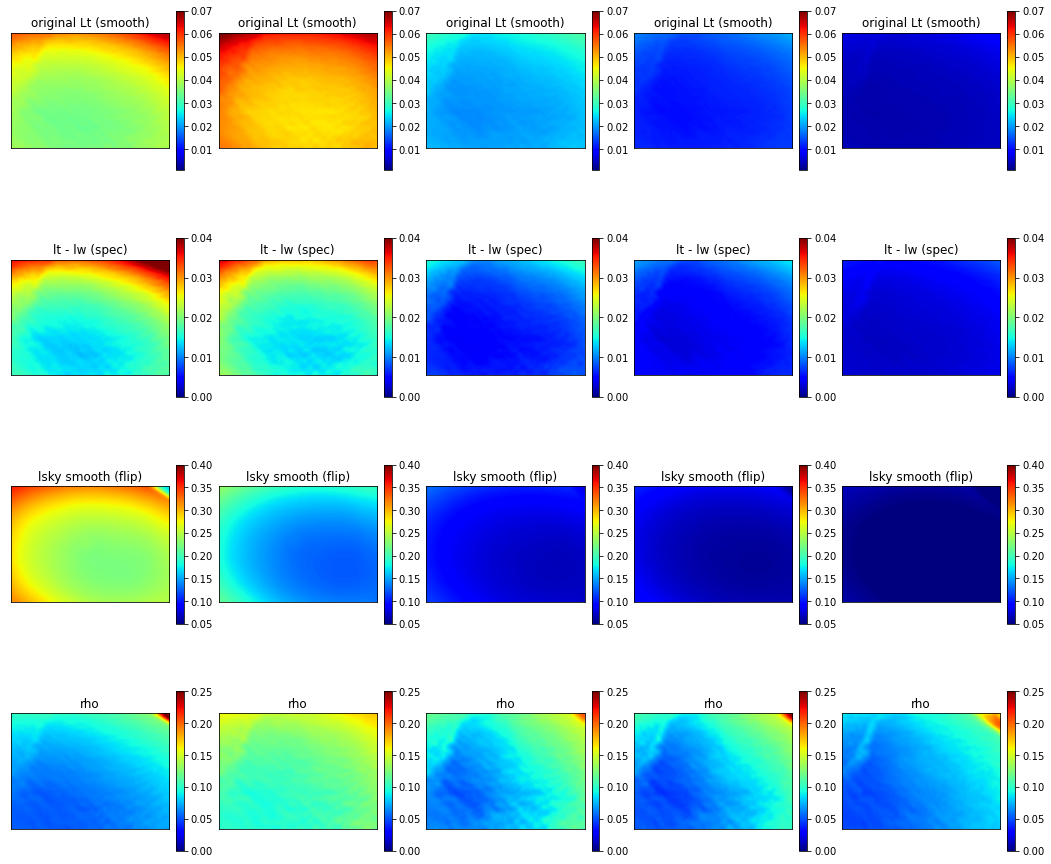

In [52]:
# this is at 135 and 40
rho = calculate_rho(sea_imgs[28,:5][np.newaxis,...], 
              sky_imgs[30,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(5, 1470, 2014)


/home/clifgray/Code/ocean_color/utils.py:708: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


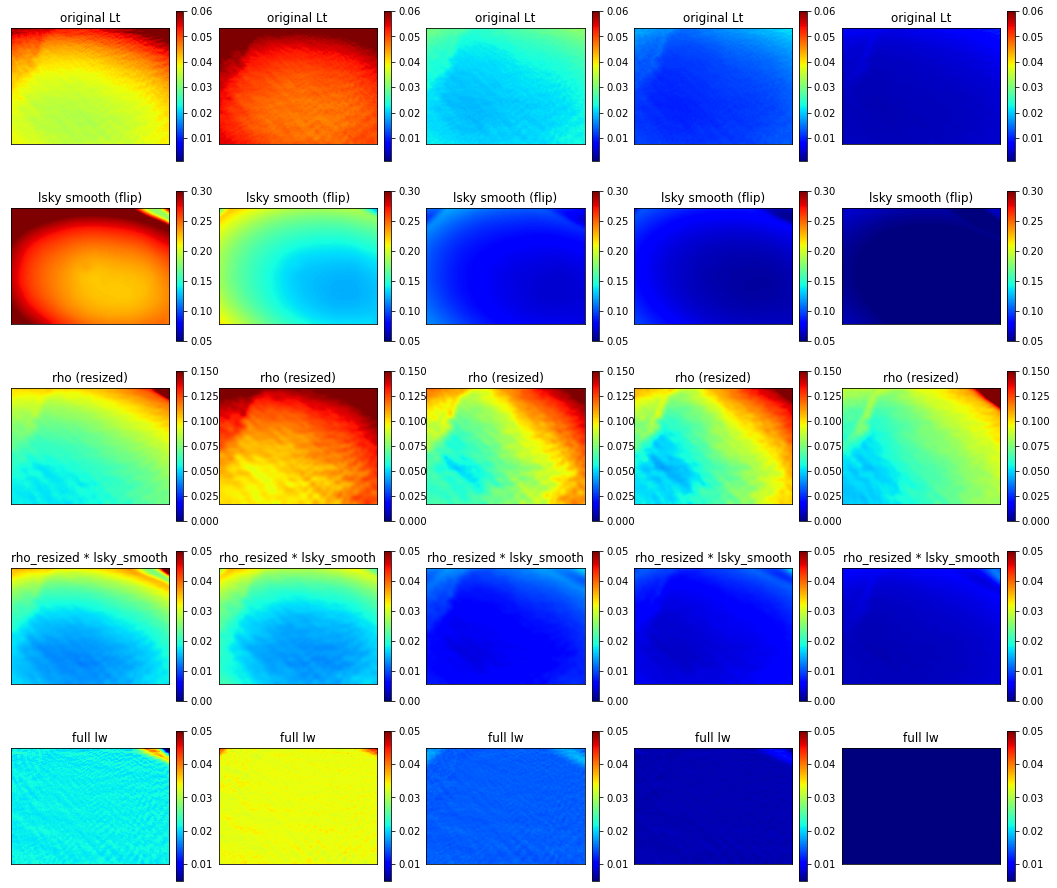

In [53]:
lw_processed = apply_rho(sea_imgs[29,:5], 
              sky_imgs[31,:5], rho, visualize=True)

#### Inspect the spectra from this

In [6]:
fig, ax = plt.subplots(figsize=(13,10))

for spectra in [np.median(sea_imgs[sea_img_md_pitch_sort[7]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='blue', alpha=0.5)
    
for spectra in [np.median(lw_processed,axis=(1,2))]:
    ax.plot(band_names, spectra, color='green', alpha=0.5)

for spectra in blocked_spectra:
    ax.plot(band_names, spectra, color='pink', alpha=0.5)
    
for spectra in [np.median(sky_imgs[sky_img_md_pitch_sort[3]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='lightblue', alpha=0.7)
    
#ax.plot(band_names, np.median(sky_spectra[0], axis=0), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

NameError: name 'plt' is not defined

#### What does chla look like from these images

In [54]:
chla_lw = vec_chla_img(lw_processed[0], lw_processed[1])

/home/clifgray/Code/ocean_color/utils.py:550: RuntimeWarning: invalid value encountered in log10
  + a4 * (np.log10(blue / green))**4


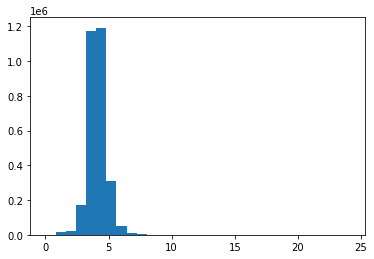

In [55]:
plt.hist(chla_lw.flatten(), bins=30)
plt.show()

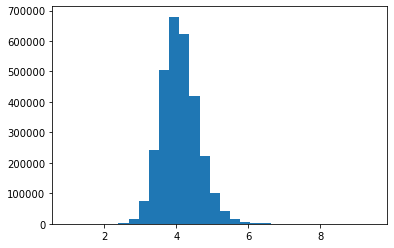

In [30]:
plt.hist(chla_lw.flatten(), bins=30)
plt.show()

In [24]:
chla_lw[300:, 100:-100].shape

(1170, 1814)

In [57]:
np.nanmedian(chla_lw)

4.065873429901383

In [26]:
np.median(chla_lw[300:, 100:-100])

4.070752121352445

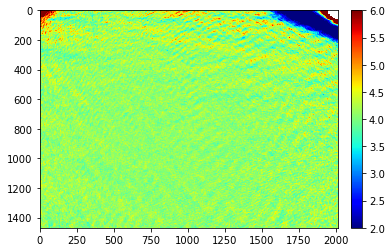

In [58]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

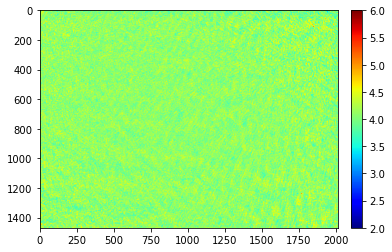

In [31]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [32]:
chla_lw.shape

(1470, 2014)

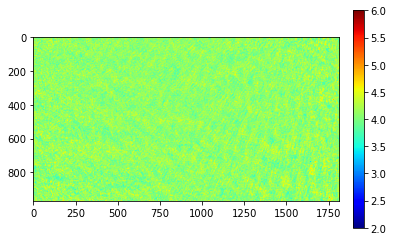

In [33]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw[500:, 100:-100], cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

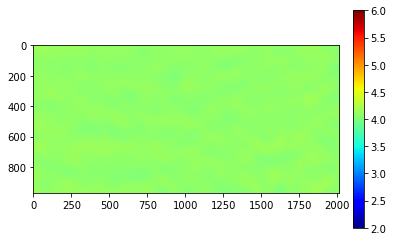

In [34]:
fig,ax = plt.subplots()
im = ax.imshow(ndimage.gaussian_filter(chla_lw[500:, :], sigma=(30, 30), order=0), cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

#### Now visualize a bunch of images and the chla from them

pitch: 0.7813185964237164
yaw: 304.93347128816885


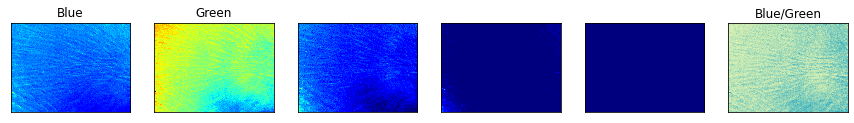

pitch: 2.8484284979807057
yaw: 302.53077525335925


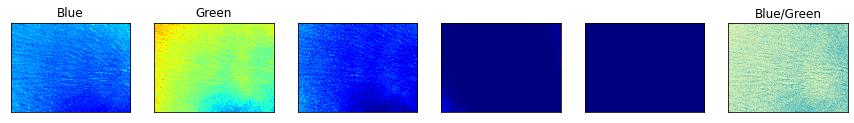

pitch: 3.6206177658294223
yaw: 301.4414487410652


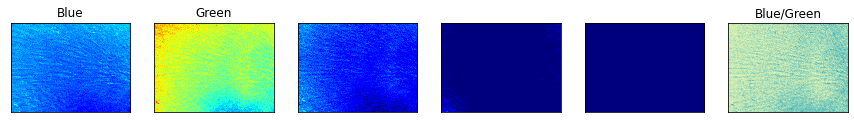

pitch: 4.721692730735867
yaw: 298.1653482965328


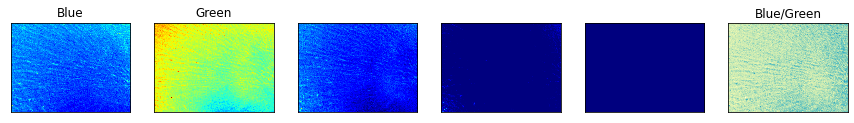

pitch: 5.120128671639236
yaw: 305.2211089662284


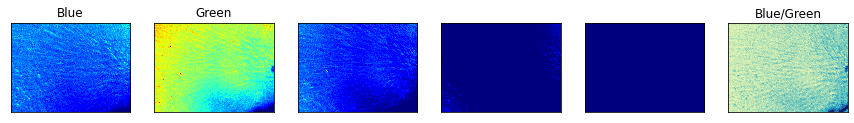

pitch: 8.867759744493128
yaw: 297.4514476679033


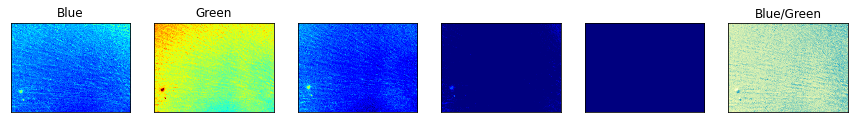

pitch: 14.537520990904625
yaw: 295.0259268435857


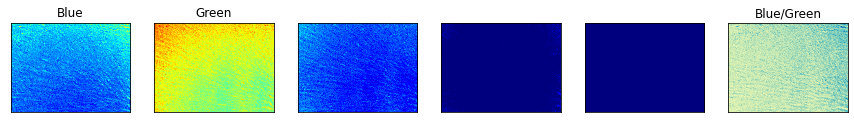

pitch: 14.72927694587986
yaw: 294.3668642045996


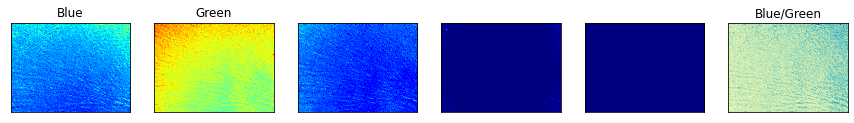

pitch: 18.58987542005042
yaw: 300.68554398471616


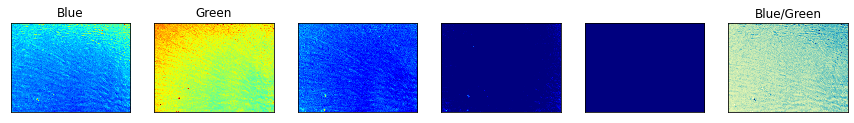

pitch: 21.552289944880386
yaw: 295.5408153471316


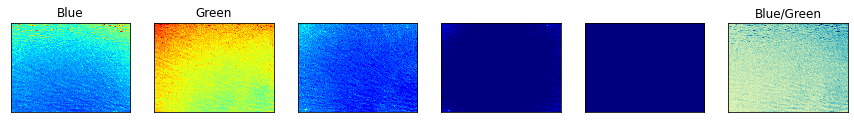

pitch: 28.688788660328328
yaw: 298.0796696209331


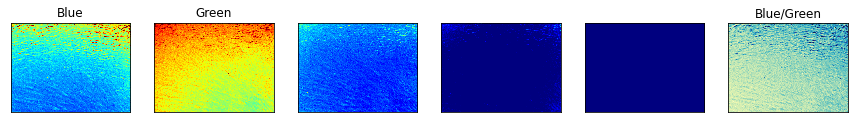

pitch: 30.059735205448305
yaw: 294.63023903277116


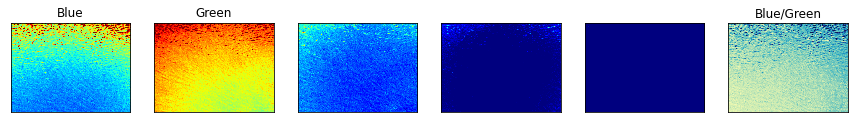

pitch: 31.532183905804573
yaw: 294.6144682255024


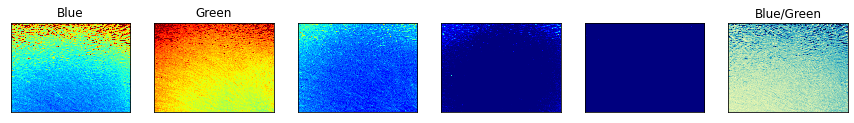

pitch: 35.50975389693423
yaw: 296.20690213826157


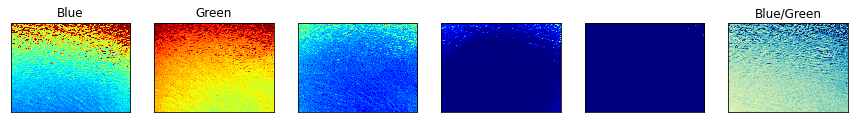

pitch: 38.21853591894268
yaw: 292.7428469723451


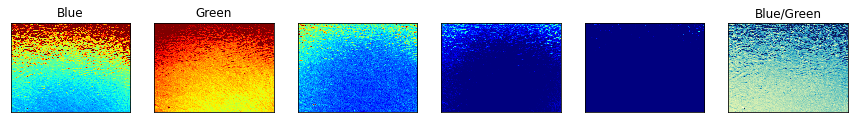

pitch: 42.79733112679867
yaw: 294.99385912732583


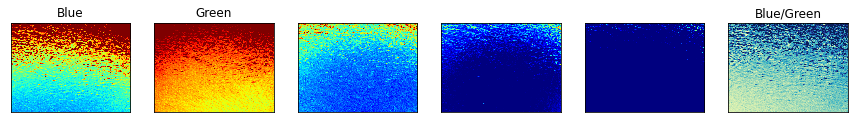

pitch: 46.578352076488784
yaw: 292.1382280748443


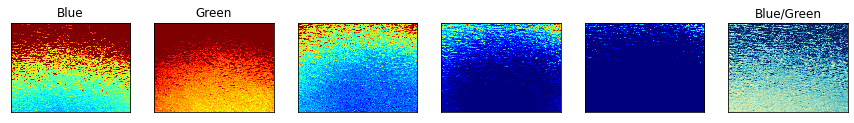

pitch: 50.35286895742746
yaw: 291.97495226550814


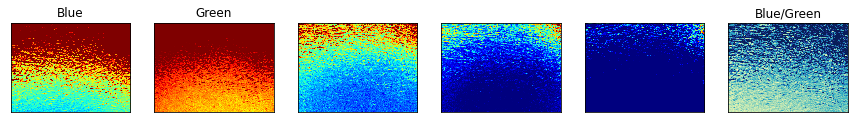

pitch: 58.804622029358086
yaw: 287.4272326639197


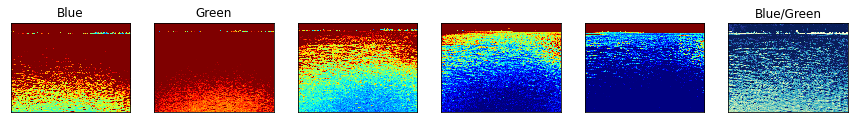

In [225]:
for i in range(0,19):
    fig, ax = plt.subplots(1,6, figsize=(15,3))
    print('pitch:',sea_img_md_pitch_sort[i]['pitch'])
    print('yaw:',sea_img_md_pitch_sort[i]['yaw'])
    ax[0].set_title("Blue")
    im = ax[0].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    #fig.colorbar(im,ax=ax[0])
    ax[1].set_title("Green")
    im2 = ax[1].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    #fig.colorbar(im2,ax=ax[1])
    im3 = ax[2].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],2], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    #fig.colorbar(im2,ax=ax[2])
    im4 = ax[3].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],3], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    #fig.colorbar(im2,ax=ax[3])
    im5 = ax[4].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],4], interpolation='none', 
                   cmap='jet', vmin=0.02, vmax=.06)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[5].set_title("Blue/Green")
    im6 = ax[5].imshow(sea_imgs[sea_img_md_pitch_sort[i]['id'],0]/sea_imgs[sea_img_md_pitch_sort[i]['id'],1], interpolation='none', 
                   cmap='YlGnBu', vmin=.5, vmax=1.2)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    #fig.colorbar(im2,ax=ax[4])
    plt.show()

### Chlorophyll retrieval algorithm

Run chla retrieval on water leaving spectra

In [66]:
chla_list = []
for spectra in blocked_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[6.356087606017864,
 6.258882462214956,
 6.555905398674276,
 6.437045009156115,
 6.0705909634053805,
 6.0467082739748275,
 6.1363390346805025]

In [67]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[3.725178152219733]

In [294]:
4.50674749003831 / 3.778

1.1928924007512731

In [68]:
for md in sea_img_metadata[:]:
    print(md['pitch'])

24.48100439092184
18.278774752899437
16.62868657249811
30.335922246084635
34.914430565022315
37.5013787624174
34.73575007534288
45.9768427574661
51.218735490343306
57.236565622612886
52.02441024442453
46.67323453974166
42.0941159243867
37.69342367764301
29.24397755315249
49.92532694279146


### Save spectra and chla values as a geopandas dataframe along with image metadata

In [69]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [ ]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])
print(len(gdf))
gdf.head()

In [ ]:
import contextily as ctx
gdf.set_crs(epsg=4326, inplace=True)
web_merc_gdf = gdf.to_crs(epsg=3857)
fig,ax = plt.subplots(figsize=(12,12))
web_merc_gdf.plot(ax=ax, column='chla', vmax=6, vmin=3)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot(ax=ax)
ctx.add_basemap(ax, zoom=12)
ax.set_ylim(4123102,4126102)
ax.set_xlim(-8537315, -8532315)

Save out the file

In [185]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')